<h1 style='text-align: center;'> 
A Brief Introduction to the Julia Library DiffEqFlux.jl 
</h1>

`Narváez J.`
<p style='text-align: justify;'>

<p style='text-align:justify;'>
In this notebook, we introduce Julia's library DiffEqFlux.jl, which fuses neural networks and differential equations. To illustrate its operation, we will create simple examples of solving ODES.
</p>

## Introduction

<p style='text-align: justify;'>  
DiffEqFlux.jl is a deep-learning library built using Julia's ecosystem of SciML. It integrates the field of differential equations (DEs) with the world of Machine Learning (ML) through the implementation of differential equations by Neural Networks (NNs). Along the way, Julia's solvers for DEs have been embedded in the Flux package to improve the testing and optimization process within NNs. In this way, it has resulted in an easy way to include a compendium of different DEs models into NNs.
</p>

<p style='text-align: justify;'>
Among other motivations for fusing DEs and ML, we can list Nonlinearities (NLs). As we know, the Universe is full of NLs, e.g., the pendulum equation, the N-body problem, fluids mechanics, and so on. Here, three common ways to include nonlinearity in a system are direct modelling, machine learning, and differential equations. 
</p>


|<img src="./Images/NLs.png" width=700 height=200 aling="center"/>|
|:--:|
| <b> Including Nonlinearities</b>|

## Task 1: Ideal Mass-Spring

$$
H = \frac{1}{2}kq^2+\frac{p^2}{2m}
$$

In [2]:
using Flux, DiffEqFlux, DifferentialEquations, Statistics, Plots, ReverseDiff

In [3]:
t = range(0.0f0, 1.0f0, length = 1024)
π_32 = Float32(π)
q_t = reshape(sin.(2π_32 * t), 1, :)
p_t = reshape(cos.(2π_32 * t), 1, :)
dqdt = 2π_32 .* p_t
dpdt = -2π_32 .* q_t

data = cat(q_t, p_t, dims = 1)
target = cat(dqdt, dpdt, dims = 1)

2×1024 Matrix{Float32}:
  6.28319   6.28307     6.28271    …  6.28271    6.28307     6.28319
 -0.0      -0.0385906  -0.0771797     0.0771784  0.0385909  -1.09859f-6

In [4]:
dataloader = Flux.Data.DataLoader((data, target); batchsize=256, shuffle=true)

hnn = HamiltonianNN(Chain(Dense(2, 64, relu), Dense(64, 1)))

p = hnn.p

opt = ADAM(0.01)

loss(x, y, p) = mean((hnn(x, p) .- y) .^ 2)

callback() = println("Loss Neural Hamiltonian DE = $(loss(data, target, p))")

epochs = 500
for epoch in 1:epochs
    for (x, y) in dataloader
        gs = ReverseDiff.gradient(p -> loss(x, y, p), p)
        Flux.Optimise.update!(opt, p, gs)
    end
    if epoch % 100 == 1
        callback()
    end
end
callback()

Loss Neural Hamiltonian DE = 17.461386
Loss Neural Hamiltonian DE = 0.026082136
Loss Neural Hamiltonian DE = 0.012713353
Loss Neural Hamiltonian DE = 0.009500688
Loss Neural Hamiltonian DE = 0.008316994
Loss Neural Hamiltonian DE = 0.007468328


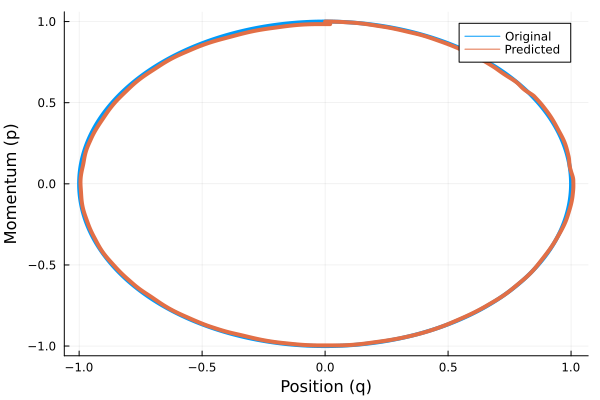

In [5]:
model = NeuralHamiltonianDE(
            hnn, (0.0f0, 1.0f0),
            Tsit5(), save_everystep = false,
            save_start = true, saveat = t
            )

pred = Array(model(data[:, 1]))
plot(data[1, :], data[2, :], lw=4, label="Original")
plot!(pred[1, :], pred[2, :], lw=4, label="Predicted")
xlabel!("Position (q)")
ylabel!("Momentum (p)")

In [12]:
q_t[:]

1024-element Vector{Float32}:
  0.0
  0.006141883
  0.012283534
  0.018424721
  0.024565214
  0.03070478
  0.036843188
  0.042980205
  0.049115602
  0.055249147
  0.061380602
  0.06750975
  0.073636346
  ⋮
 -0.06750959
 -0.061380226
 -0.055249028
 -0.049115267
 -0.042980127
 -0.03684289
 -0.030704742
 -0.024564957
 -0.018424723
 -0.012283319
 -0.006141926
  1.7484555f-7

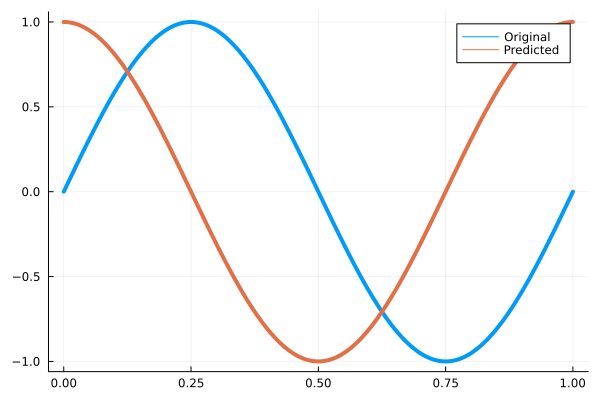

In [13]:
plot(t, q_t[:], lw=4, label="Original")
plot!(t, p_t[:], lw=4, label="Predicted")

In [20]:
function HSpring(q, p; k=1., m=1)
    H = 0.5*k*q^2 + 0.5*p^2/m
    return H
end;

function PSpring(H, q; k=1., m=1)
    p = sqrt(2*m*(H-0.5*k*q^2))
    return p
end;

In [33]:
Energy = range(0.2f0, 1.0f0, length = 25)

0.2f0:0.033333335f0:1.0f0

In [34]:
q = range(-0.9f0, 0.9f0, 15)
p = PSpring.(Energy[1], q)

LoadError: DomainError with -0.40999993681907654:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

In [17]:
lr = 1e-3 # learning rate
epochs = 2000 # Number of iterations
logstep = 100; # Period to store loss in history
opt = Flux.Adam(lr); # ADAM method (Stochastic optimization)
data = Iterators.repeated((), 1);
#loss = Flux.Losses.mse()

In [14]:
# We define a NN with: 1 input layer, 2 hidden layers and 1 output layer
NNODE = Chain(t -> [t], # Take in a scalar and transform it into an array
            Dense(1, 200, tanh), # It uses the hyperbolic tangent as activation function
            Dense(200, 200, tanh),
            Dense(200, 200, tanh),
            Dense(200,1), first) # Take first value, i.e. return a scalar
NNODE(1.0)

0.20696336437766027

## References

1. `Rackauckas, Chris & Ma, Yingbo & Martensen, Julius & Warner, Collin & Zubov, Kirill & Supekar, Rohit & Skinner, Dominic & Ramadhan, Ali. (2020). Universal Differential Equations for Scientific Machine Learning. 10.21203/rs.3.rs-55125/v1.`

2. `Rackauckas, Chris & Innes, Mike & Ma, Yingbo & Bettencourt, Jesse & White, Lyndon & Dixit, Vaibhav. (2019). DiffEqFlux.jl - A Julia Library for Neural Differential Equations.`https://julialang.org/blog/2019/01/fluxdiffeq